# Vividness Features: Individual Differences

In this analysis of participants across all experiments, we are looking at individual differences in memory profiles, specifically which memory attributes correlate with memory vividness and if there are differences in this pattern across individuals. This is analysed in two ways:  

* By looking at correlations between memory attributes and with the SAM/VVIQ
* By using K-Means clustering to look at patterns of vividness correlations (specificity vs. content)

Note that memory scores are standardised across participants *within* each experiment group first to remove any mean differences in performance.  

# Sections

1. Load Data  
2. **Memory Attribute Correlations**     
3. **Questionnaire Correlations**     
4. **Vividness Correlation Memory Profiles**    

***

# 1. Load Data

In [1]:
# load my functions:
import importlib, sys, os
sys.path.append(os.getcwd())

import individual_differences_functions
importlib.reload(individual_differences_functions)
from individual_differences_functions import *

In [2]:
import warnings
warnings.simplefilter('ignore')

# basic packages:
import pandas as pd
import numpy as np

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import set_matplotlib_formats
import seaborn as sns
import networkx as nx

# stats
from scipy import stats
import pingouin as pg
from sklearn.preprocessing import StandardScaler

%matplotlib inline
set_matplotlib_formats('pdf', 'svg')

Load in csv data files from all experiments:

In [3]:
# find all csvs
data_dir = '../data/'
print('Fetching data from:',data_dir)

exp1_files = pd.read_csv(data_dir + 'included_participants_exp1.csv', header=None, names=['File'])
exp1_files['Group'] = '1'
exp2_files = pd.read_csv(data_dir + 'included_participants_exp2.csv', header=None, names=['File'])
exp2_files['Group'] = '2'
exp3_files = pd.read_csv(data_dir + 'included_participants_exp3.csv', header=None, names=['File'])
exp3_files['Group'] = ''
exp3_files.Group[exp3_files.File.str.find('grpA') > 0] = '3a'
exp3_files.Group[exp3_files.File.str.find('grpB') > 0] = '3b'

print('\nFound:\n',exp1_files.shape[0],'experiment 1 participants\n',exp2_files.shape[0],'experiment 2 participants\n',exp3_files.shape[0],'experiment 3 participants\n')

# merge
exp_files = pd.concat([exp1_files, exp2_files, exp3_files]).reset_index(drop=True)
print('Total N =',len(exp_files),'\n')

Fetching data from: ../data/

Found:
 48 experiment 1 participants
 35 experiment 2 participants
 72 experiment 3 participants

Total N = 155 



Load and merge all subject data files into a single dataframe, marking which experiment they come from:

In [4]:
print('Merging data files...')
my_list = [] 
for i in range(exp_files.shape[0]):

    df = pd.read_csv(exp_files.File[i], index_col=None, header=0)
    # add experiment group
    df['group'] = exp_files.Group[i]  
    # if experiment 3, drop extra columns:
    if (exp_files.Group[i] == '3a') | (exp_files.Group[i] == '3b'):
        df.drop(columns=['expName', 'resp_enc_success.keys', 'resp_enc_success.rt'], inplace=True)
    my_list.append(df)

# concatenate across subjects
my_data = pd.concat(my_list, axis=0, ignore_index=True)
print('\nData frame my_data created for all participants:')
my_data.head()

Merging data files...

Data frame my_data created for all participants:


,participant,event_id,encoding.thisN,theme,object_label,person_label,place_label,resp_encSpace.rt,retrieval.thisN,resp_ret_vividness.keys,...,resp_detailmem2.corr,resp_detailmem2.rt,resp_detailmem2.keys,resp_detailmem3.corr,resp_detailmem3.rt,resp_detailmem3.keys,familiarity.thisN,resp_facefam.keys,resp_facefam.rt,group
0,101,18.0,0.0,Work,Flowers,Beyonce,Cabin,12.607160,14.0,3.0,...,0.0,2.757795,1.0,0.0,1.851940,2.0,17.0,1.0,0.368970,1
1,101,3.0,1.0,Games,Bike,George,Wine Cellar,NaN,5.0,3.0,...,0.0,0.969740,1.0,1.0,1.990665,2.0,9.0,1.0,0.550830,1
2,101,14.0,2.0,Vacation,Satchel,Reese,Bowling,13.703325,12.0,2.0,...,1.0,1.519175,1.0,1.0,0.968145,2.0,5.0,1.0,0.656880,1
3,101,19.0,3.0,Relaxing,Backpack,Robert,Lighthouse,11.153425,13.0,2.0,...,1.0,0.886395,1.0,0.0,1.290605,1.0,4.0,2.0,1.016965,1
4,101,4.0,4.0,Art,Binoculars,Ryan,Lake,12.844150,0.0,2.0,...,1.0,2.333065,1.0,1.0,2.502490,1.0,8.0,1.0,0.553285,1


In [5]:
# check that all subjects have 24 events:
ntrials = my_data.groupby('participant').count()
if any(ntrials["event_id"] != 24):
    print('Error: at least one subject does not have 24 trials')
else:
    print('All subjects have 24 trials')

All subjects have 24 trials


## Format Data

### Mean memory scores

Mean values for my memory measures by participant:

In [6]:
# formats the above data frame into tody version -- one row per trial,
# one column for each of our 7 memory measures
memory_data = create_memory_data(my_data)
memory_data.head()

,participant,group,event,vividness,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place
0,101,1,18.0,3.0,0.0,0.0,1.0,0.0,1.0,0.0
1,101,1,3.0,3.0,0.0,0.0,1.0,0.0,0.0,1.0
2,101,1,14.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0
3,101,1,19.0,2.0,1.0,0.0,0.0,1.0,1.0,1.0
4,101,1,4.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0


Overall performance of the groups for our memory measures? (Should match values in the individual experiment notebooks)

In [7]:
# summarise across all trials (events) per subject
memory_summary = memory_data.groupby(['participant','group']).mean().drop('event',axis=1).reset_index()

# print average performance for each experiment group:
memory_summary.groupby('group').describe().drop(columns='participant').loc[:, (slice(None), ['mean','std'])]

vividness           detail_object           detail_person            \
           mean       std          mean       std          mean       std   
group                                                                       
1      2.615451  0.964739      0.758681  0.115942      0.739583  0.144976   
2      3.507143  0.927602      0.758333  0.106853      0.773810  0.117975   
3a     3.962963  1.023716      0.791667  0.131762      0.771991  0.111575   
3b     3.780093  1.026224      0.734954  0.111427      0.750000  0.106812   

      detail_place           gist_object           gist_person            \
              mean       std        mean       std        mean       std   
group                                                                      
1         0.705729  0.136824    0.714410  0.201390    0.656250  0.178544   
2         0.727381  0.113139    0.828571  0.174384    0.769048  0.143750   
3a        0.737269  0.146662    0.818287  0.172560    0.740741  0.188486   
3b        0.732639  0.103689    0.803241  0.182468    0.709491  0.197073   

      gist_place            
            mean       std  
group                       
1       0.726562  0.216746  
2       0.836905  0.163690  
3a      0.824074  0.173694  
3b      0.790509  0.180246

In [8]:
#get float (memory measure) columns:
float_cols = ['vividness', 'gist_object', 'gist_person', 'gist_place', 'detail_object', 'detail_person', 'detail_place']

In [9]:
# Difference in performance between groups (standardised across all subjects)
scaler = StandardScaler()
memory_temp = memory_summary.copy()
memory_temp[float_cols] = scaler.fit_transform(memory_temp[float_cols])

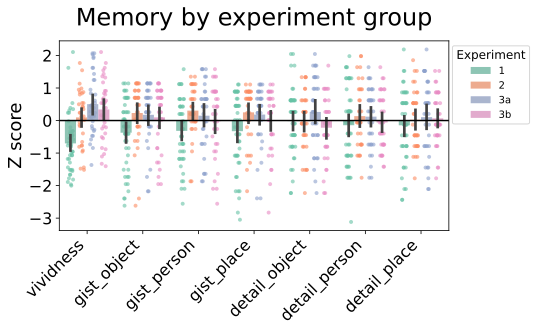

In [10]:
plot_data = memory_temp.melt(value_vars=float_cols, var_name='Measure',
                             value_name='Z', id_vars=['participant','group'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
            hue="group", palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              hue="group", palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=18)
plt.yticks(fontsize=16)
plt.title('Memory by experiment group', fontsize=24, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
# add legend:
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[4:9], labels[4:9],
           loc='upper right', bbox_to_anchor=(1.22, 1), 
           fontsize=10, title="Experiment", title_fontsize=12)
plt.show()

Now, standardise *within* each group before running our analyses:

In [11]:
#zscore *within* group (and get features on the same scale)
memory_norm = memory_summary.copy()
for g in memory_norm.group.unique():        
    idx = memory_norm[memory_norm.group == g].index
    memory_norm.loc[idx,float_cols] = scaler.fit_transform(memory_norm.loc[idx,float_cols])

Plot standardised data and mark outliers (|z| > 2.5)

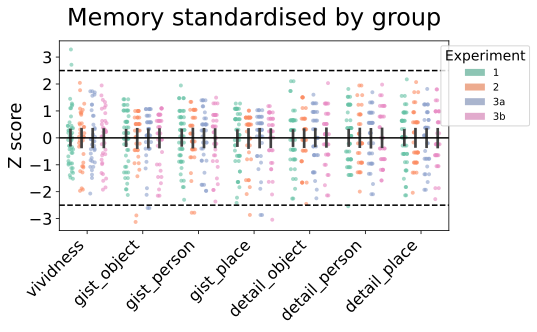

In [12]:
# plot standardized (within group) variables:
plot_data = memory_norm.melt(value_vars=float_cols, var_name='Measure',
                             value_name='Z', id_vars=['participant','group'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
            hue="group", palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              hue="group", palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=18)
plt.yticks(fontsize=16)
plt.title('Memory standardised by group', fontsize=24, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
plt.axhline(-2.5,ls="--",color="black")  #outlier
plt.axhline(2.5,ls="--",color="black")  #outlier
# add legend:
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[4:9], labels[4:9],
           loc='upper right', bbox_to_anchor=(1.22, 1), 
           fontsize=10, title="Experiment", title_fontsize=14)
plt.show()

#### Remove outliers

Remove any subjects that have a z-score of >|2.5| (outside of the dashed line in above plot)

In [13]:
memory_norm_all = memory_norm.copy()

# set outliers to nan
memory_norm[memory_norm[float_cols].abs() > 2.5] = np.nan
# remove any subjects with a nan
memory_norm.dropna(inplace=True)

In [14]:
print('\nNumber of subjects with memory scores after removing outliers =',memory_norm.shape[0],'\n')


Number of subjects with memory scores after removing outliers = 147 



In [15]:
## re-do z-scoring to reflect relative performance compared to current sample (still within experiment)
for g in memory_norm.group.unique():        
    idx = memory_norm[memory_norm.group == g].index
    memory_norm.loc[idx,float_cols] = scaler.fit_transform(memory_norm.loc[idx,float_cols])     
memory_norm.head()

,participant,group,vividness,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place
0,101,1,0.610768,-0.025126,-0.871740,-0.559960,0.424264,0.077262,0.530458
1,102,1,0.339182,1.859320,1.379064,1.672792,1.484924,1.567316,1.112669
2,103,1,1.534163,1.859320,-0.228653,1.353827,1.272792,1.567316,1.112669
3,105,1,1.751432,-2.286461,-0.550197,-0.559960,-1.484924,-0.171080,-2.186523
5,109,1,-1.018752,0.351763,0.092890,-0.559960,-0.636396,0.325604,-0.245822


### Vividness correlations

Now that we have the mean memory scores per subject, I'm constructing a similar dataframe but this time with the within-subject correlations between subjective vividness and the objective memory attributes. As in the individual experiment notebooks, gist-vividness correlations include all trials whereas detail-vividness correlations are conditional on correct gist memory.  

In [16]:
# calculate gist-specific correlations
cor_params_gist = vividness_correlations(memory_data, ["gist_object","gist_person","gist_place"])

In [17]:
# calculate detail-specific correlations (where gist = 1)
cor_detail_object = vividness_correlations(memory_data[memory_data.gist_object == 1], ["detail_object"])
cor_detail_person = vividness_correlations(memory_data[memory_data.gist_person == 1], ["detail_person"])
cor_detail_place = vividness_correlations(memory_data[memory_data.gist_place == 1], ["detail_place"])

# merge detail to single df:
cor_params_detail = cor_detail_object.merge(cor_detail_person, how="outer")
cor_params_detail = cor_params_detail.merge(cor_detail_place, how="outer")

In [18]:
cor_params = cor_params_gist.merge(cor_params_detail, how="outer").rename(columns={'index': 'participant'})
cor_params.shape

(155, 8)

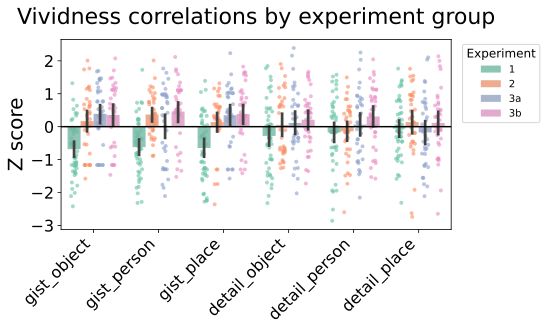

In [19]:
# Difference in vividness correlations between groups (standardised across all subjects)
cor_temp = cor_params.copy()
cor_temp[float_cols[1:]] = scaler.fit_transform(cor_temp[float_cols[1:]])

plot_data = cor_temp.melt(value_vars=float_cols[1:], var_name='Measure',
                          value_name='Z', id_vars=['participant','group'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
            hue="group", palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              hue="group", palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=20)
plt.yticks(fontsize=16)
plt.title('Vividness correlations by experiment group', fontsize=22, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
# add legend:
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[4:9], labels[4:9],
           loc='upper right', bbox_to_anchor=(1.24, 1), 
           fontsize=10, title="Experiment", title_fontsize=12)
plt.show()

In [20]:
# z-score within each group to remove mean differences
for g in cor_params.group.unique():        
    idx = cor_params[cor_params.group == g].index
    cor_params.loc[idx,float_cols[1:]] = scaler.fit_transform(cor_params.loc[idx,float_cols[1:]])
cor_params.head()

,participant,group,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
0,101,1,-0.902769,-1.435038,-0.452237,1.111755,1.637009,-1.034478
1,102,1,-0.582481,0.23749,-0.984109,-1.234224,1.690906,0.334269
2,103,1,0.786609,-0.065054,-0.18122,-1.416368,0.038467,1.031275
3,105,1,-0.854947,1.352938,0.53089,0.578176,-1.735661,-0.939298
4,108,1,-0.582481,-0.781826,-0.68717,-0.055512,-0.435621,-0.459561


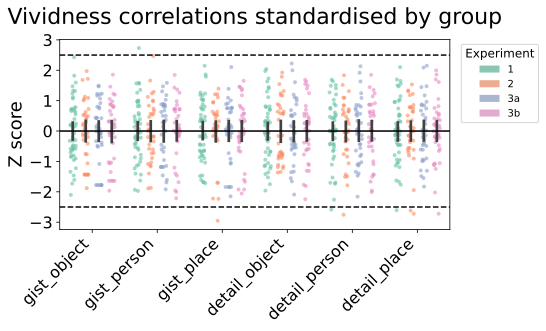

In [21]:
# plot standardised (within group) variables:
plot_data = cor_params.melt(value_vars=float_cols[1:], var_name='Measure',
                            value_name='Z', id_vars=['participant','group'])

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='Z',
            hue="group", palette="Set2", alpha=.8)
g = sns.stripplot(data=plot_data, x='Measure', y='Z',
              hue="group", palette="Set2", jitter=.2,
              dodge=True, size=4, zorder=0, alpha=.6)
plt.xlabel("")
plt.xticks(fontsize=16, rotation=45, ha="right")
plt.ylabel("Z score", fontsize=18)
plt.yticks(fontsize=16)
plt.title('Vividness correlations standardised by group', fontsize=22, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
plt.axhline(-2.5,ls="--",color="black")  #outlier
plt.axhline(2.5,ls="--",color="black")  #outlier
# add legend:
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[4:9], labels[4:9],
           loc='upper right', bbox_to_anchor=(1.24, 1), 
           fontsize=10, title="Experiment", title_fontsize=12)
plt.show()

#### Remove outliers

Remove any subjects that have a z-score of >|2.5| (outside of the dashed line in above plot)

In [22]:
# set outliers to nan
cor_params[cor_params[float_cols[1:]].abs() > 2.5] = np.nan
cor_params.dropna(inplace=True)

In [23]:
print('\nNumber of subjects for vividness correlations after removing outliers =',cor_params.shape[0],'\n')


Number of subjects for vividness correlations after removing outliers = 147 



In [24]:
## re-do z-scoring to reflect relative performance compared to current sample (still within experiment)
for g in cor_params.group.unique():        
    idx = cor_params[cor_params.group == g].index
    cor_params.loc[idx,float_cols[1:]] = scaler.fit_transform(cor_params.loc[idx,float_cols[1:]])
cor_params.head()

,participant,group,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
0,101,1,-0.884582,-1.46378,-0.420923,1.114018,1.64652,-1.223391
1,102,1,-0.545011,0.304594,-0.971885,-1.210242,1.703194,0.307209
2,103,1,0.906505,-0.015288,-0.140179,-1.390698,-0.03438,1.086635
3,105,1,-0.833881,1.483963,0.59749,0.585379,-1.89991,-1.116956
4,108,1,-0.545011,-0.773135,-0.664288,-0.042442,-0.532892,-0.580491


# 2. Memory Attribute Correlations

How are our different memory measures correlated across participants?

In [25]:
# correlate
memory_cors_norm = memory_norm[float_cols].corr(method='spearman')   
np.fill_diagonal(memory_cors_norm.values, np.nan)

# and define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(memory_cors_norm, memory_norm.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

bonferroni-corrected critical r = 0.232


As a heatmap. * = p < .05 uncorrected, ** = p < .05 bonferroni-corrected

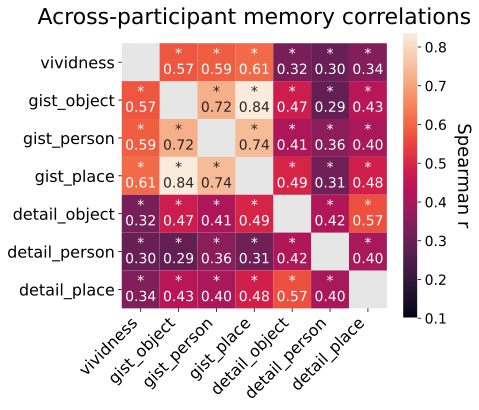

In [26]:
plot_cor_heatmap(memory_cors_norm, l = labels, cmap="rocket", title = 'Across-participant memory correlations')
plt.show()

The pairwise scatter plots showing relationships between attributes and vividness:

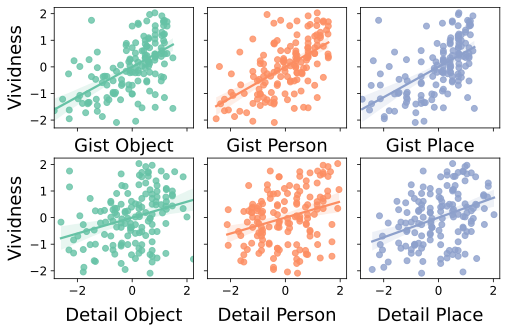

In [27]:
# get colors:
this_cmap = cm.get_cmap("Set2", 8) 
this_hex = []
for i in range(this_cmap.N):
    rgb = this_cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    this_hex.append(mpl.colors.rgb2hex(rgb))

# plot:
fig, axes = plt.subplots(2, 3, figsize=(8,5), 
                         sharex=True, sharey=True,
                         gridspec_kw={
                               'wspace': 0.1,
                               'hspace': 0.25})

features = float_cols[1:]
n=-1
for a in range(2):
    for b in range(3):
        n=n+1
        sns.regplot(ax=axes[a, b],
                    data=memory_norm[['vividness'] + [features[n]]],
                    x = features[n], y = 'vividness',
                    color=this_hex[b])
        plt.axes(axes[a,b])
        xlab = features[n].split('_')
        plt.xlabel(xlab[0].capitalize() + ' ' + xlab[1].capitalize(), 
                   fontsize=18, labelpad = 10)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        if b == 0:
            plt.ylabel('Vividness', fontsize=18, labelpad = 5)
        else:
            plt.ylabel('')
            
# save 
plt.savefig("plots/across_subject_scatter.pdf", bbox_inches = 'tight')
plt.show()

# 3. Questionnaire Correlations

SAM and VVIQ  

**SAM variables:**  
* ep = episodic
* sem = semantic
* spa = spatial
* fut = future

**VVIQ variables:**  
per/sun/shop/scene (collapse across all)

There should be N-1 subjects for questionnaires as the first participant of Exp 1 didn't complete them.

In [28]:
# Read in questionnaire data
ques_Exp1 = pd.read_csv(data_dir + 'questionnaire_data_exp1.csv', index_col=None, header=0)
ques_Exp2 = pd.read_csv(data_dir + 'questionnaire_data_exp2.csv', index_col=None, header=0)
ques_Exp3 = pd.read_csv(data_dir + 'questionnaire_data_exp3.csv', index_col=None, header=0)
ques = pd.concat([ques_Exp1,ques_Exp2,ques_Exp3])
ques.participant = ques.participant.astype('string')

First, run item-specific reverse-coding for the SAM. This was not implemented in data collection (where all SAM items were coded as 1-5 for strongly disagree to agree).  

In [29]:
reverse_cols = ["ep1","ep2","sem2","sem5","spa3","spa4","fut6"]
ques[reverse_cols] = 6 - ques[reverse_cols]

Now create aggregate scores by averaging across subset items -- Mostly care about episodic SAM and VVIQ:

In [30]:
cols = [i for i in ques.columns if "ep" in i] 
ques['SAM_episodic'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "sem" in i] 
ques['SAM_semantic'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "spa" in i] 
ques['SAM_spatial'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if "fut" in i] 
ques['SAM_future'] = ques[cols].mean(axis=1)

cols = [i for i in ques.columns if any(p in i for p in ["per_","sun_","shop_","scene_"])]
ques['Visual_imagery'] = ques[cols].mean(axis=1)

In [31]:
ques_all = ques.copy()
ques.shape
# note that the first subject of Experiment 1 did not complete the questionnaires (hence 154, not 155 to begin with)

(154, 48)

In [32]:
#finally, merge with (filtered) memory data
memory_norm.participant = memory_norm.participant.astype('string')
ques = ques.merge(memory_norm, on='participant')
ques.shape

(146, 56)

In [33]:
ques.head()

,participant,ep1,ep2,ep3,ep4,ep5,ep6,ep7,ep8,sem1,...,SAM_future,Visual_imagery,group,vividness,detail_object,detail_person,detail_place,gist_object,gist_person,gist_place
0,102,4,3,4,4,4,4,2,4,4,...,4.166667,3.8125,1,0.339182,1.859320,1.379064,1.672792,1.484924,1.567316,1.112669
1,103,4,4,5,1,4,4,2,3,5,...,3.000000,4.0000,1,1.534163,1.859320,-0.228653,1.353827,1.272792,1.567316,1.112669
2,105,3,4,4,3,4,4,1,5,4,...,4.333333,4.3750,1,1.751432,-2.286461,-0.550197,-0.559960,-1.484924,-0.171080,-2.186523
3,109,4,4,3,3,3,3,4,4,4,...,4.000000,3.0625,1,-1.018752,0.351763,0.092890,-0.559960,-0.636396,0.325604,-0.245822
4,111,3,3,4,4,4,5,2,3,4,...,3.833333,3.8125,1,-0.203992,-1.155793,0.092890,-1.835818,0.636396,0.573947,0.142318


Correlation between questionnaire measures?

bonferroni-corrected critical r = 0.213


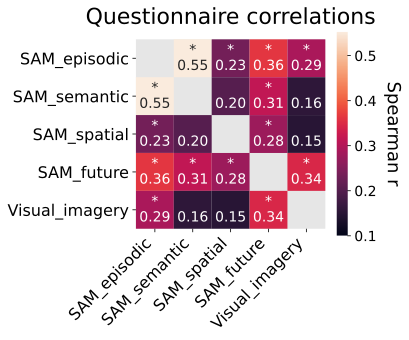

In [34]:
measures = ['SAM_episodic', 'SAM_semantic', 'SAM_spatial', 'SAM_future', 'Visual_imagery']

ques_data = ques[measures]
ques_cors = ques_data.corr(method='spearman')
np.fill_diagonal(ques_cors.values, np.nan)

# define which correlations are significant based on critical r:
pmask, labels, r_sig = fetch_sig_cors(ques_cors, ques.shape[0])
print('bonferroni-corrected critical r =',np.round(r_sig,3))

# plot correlations
plot_cor_heatmap(ques_cors, l = labels, cmap="rocket", title='Questionnaire correlations')

Now let's focus on the correlation between the SAM_episodic and Visual_imagery with our measured memory attributes.

In [35]:
measures = ['SAM_episodic','Visual_imagery']
ques_data = ques[measures + float_cols]

# calculate correlations
ques_cors = ques_data.corr(method='spearman').loc[float_cols,['vividness'] + measures]
ques_cors.loc['vividness','vividness'] = np.nan

# get significance labels:
pmask, labels, r_sig = fetch_sig_cors(ques_cors, ques_data.shape[0], sym=False)
print('bonferroni-corrected critical r =',np.round(r_sig,3))

bonferroni-corrected critical r = 0.231


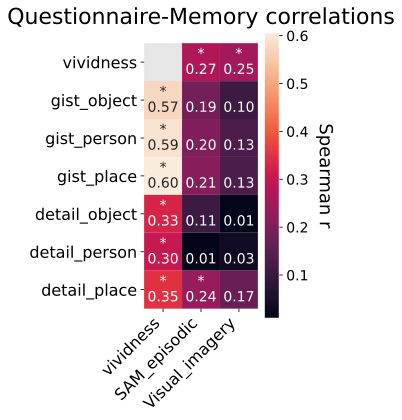

In [36]:
# plot correlations
plot_cor_heatmap(ques_cors, l=labels, cmap="rocket", title='Questionnaire-Memory correlations')
# save 
plt.savefig("plots/questionnaire_correlations.pdf", bbox_inches = 'tight')
plt.show()

# 4. Memory Profiles
Do subjects cluster in the relationship between vividness and the content and/or specificity of their memories? K-Means clustering applied to standardised within-subject correlations.

In [37]:
memory_values = cor_params.drop(columns=['group']).set_index('participant')
memory_values.head()

,gist_object,gist_person,gist_place,detail_object,detail_person,detail_place
participant,,,,,,
101,-0.884582,-1.46378,-0.420923,1.114018,1.64652,-1.223391
102,-0.545011,0.304594,-0.971885,-1.210242,1.703194,0.307209
103,0.906505,-0.015288,-0.140179,-1.390698,-0.03438,1.086635
105,-0.833881,1.483963,0.59749,0.585379,-1.89991,-1.116956
108,-0.545011,-0.773135,-0.664288,-0.042442,-0.532892,-0.580491


Run iterations over several values of k to find the optimal number of clusters for our data:

Using 3 clusters for K-Means


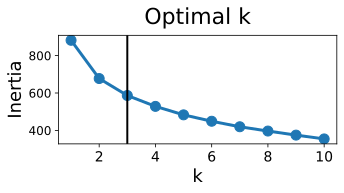

In [38]:
r_state=12
myk = find_optimal_k(memory_values, r_state)

In [39]:
# Run K-Means using myk clusters
mykmeans = KMeans(n_clusters=3, init="k-means++",
                  n_init=500,  #number of clustering attempts - returns lowest SSE
                  random_state=r_state).fit(memory_values)

# fetch cluster centroids:
centroids = pd.DataFrame(mykmeans.cluster_centers_, columns = memory_values.columns).reset_index()
kmeans_labels = mykmeans.labels_

Plot network structure of euclidean distances (closer subjects are closer together) -- show top 20% of edges

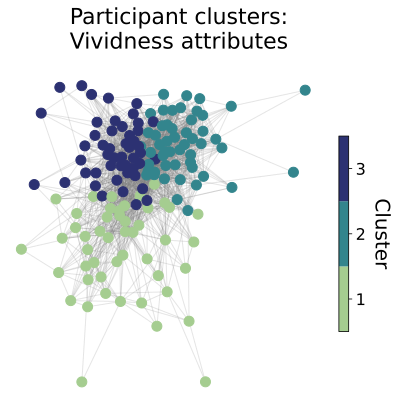

In [42]:
prop_view = .2
memory_values = memory_values.astype('float')
plot_distance_network(memory_values, kmeans_labels, prop_view, myk, ran_seed=2)

# save 
plt.savefig("plots/distances_3cluster.pdf", bbox_inches = 'tight')
plt.show()

In [43]:
# Number of subjects per cluster (check approx balanced for later averaging):
print('N subjects per cluster =\n')
print(pd.Series(kmeans_labels).value_counts().sort_index(),'\n')

N subjects per cluster =

0    48
1    51
2    48
dtype: int64 



Plot centroids of each cluster as a polar plot:

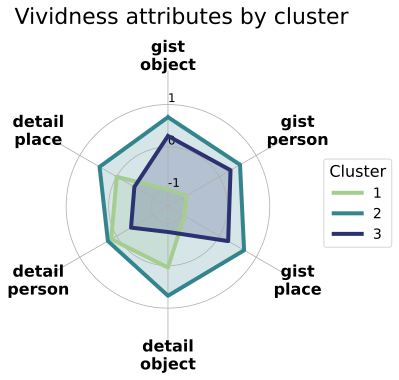

In [44]:
cluster_polar_plot(centroids, myk, -1.4, 1.8)

# save 
plt.savefig("plots/polar_3cluster.pdf", bbox_inches = 'tight')
plt.show()

Plot vividness correlations by cluster to illustrate the above difference:

In [45]:
# add cluster labels to data
memory_values['cluster'] = kmeans_labels

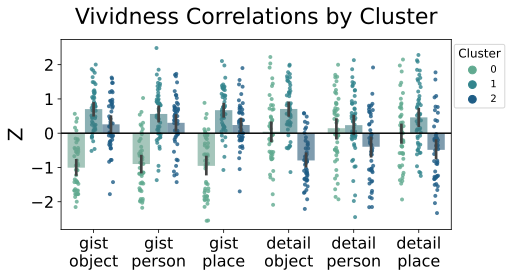

In [46]:
wrapped_labels = [ label.replace('_', '\n') for label in float_cols[1:] ]

plot_data = memory_values.reset_index().melt(value_vars=float_cols[1:], var_name='Measure',
                                             value_name='z', id_vars=['participant','cluster'])
plot_data.z = plot_data.z.astype(float)

plt.figure(figsize=(7,3.5))
sns.barplot(data=plot_data, x='Measure', y='z',
            hue="cluster", palette="crest", alpha=.6,
            dodge=True)
g = sns.stripplot(data=plot_data, x='Measure', y='z',
                  hue="cluster", palette="crest", dodge=True,
                  size=4, zorder=0, alpha=.8, jitter=.1)
# Add legend
handles, labels = g.get_legend_handles_labels()
plt.legend(handles[0:3], labels[0:3],
           loc='upper right', bbox_to_anchor=(1.15, 1), 
           fontsize=10, title="Cluster", title_fontsize=12)

plt.xlabel("")
plt.xticks(list(range(len(wrapped_labels))), wrapped_labels,
           fontsize=16, wrap=True)
plt.ylabel("Z", fontsize=20)
plt.yticks(fontsize=16)
plt.title('Vividness Correlations by Cluster', fontsize=22, y=1.05)
plt.axhline(0,ls="-",color="black")  #chance
plt.show()

**Validation of K-means partition** -- is there a significant difference between the clusters for each of the above attributes (memory-to-vividness relationship)?

In [47]:
# run one-way anova within each measure and store stats as df (for bonferroni-correction)
memory_values[float_cols[1:]] = memory_values[float_cols[1:]].astype('float')

for f in range(len(float_cols)-1):
    stats = pg.anova(data=memory_values, dv=float_cols[f+1], between='cluster', effsize="n2", detailed=True).round(4)
    stats['measure'] = float_cols[f+1]
    if f == 0:
        all_stats = stats[stats.Source == 'cluster']
    else:
        all_stats = all_stats.append(stats[stats.Source == 'cluster'])
all_stats

,Source,SS,DF,MS,F,p-unc,n2,measure
0,cluster,77.0246,2,38.5123,79.2531,0.0000,0.5240,gist_object
0,cluster,59.4185,2,29.7093,48.8475,0.0000,0.4042,gist_person
0,cluster,69.3918,2,34.6959,64.3774,0.0000,0.4721,gist_place
0,cluster,55.9785,2,27.9893,44.2802,0.0000,0.3808,detail_object
0,cluster,11.3295,2,5.6647,6.0125,0.0031,0.0771,detail_person
0,cluster,22.1972,2,11.0986,12.8058,0.0000,0.1510,detail_place


## Cluster characteristics

*Using the above clusters (based on relationships of event features to vividness), how do participants differ in other ways?*  
* Sanity check -- experiment group  
* Task performance  
* Questionnaire measures  

In [48]:
cluster_data = memory_values[['cluster']].reset_index()
cluster_data.head()

,participant,cluster
0,101,0
1,102,0
2,103,2
3,105,2
4,108,0


In [49]:
# add experiment group, task performance, and questionnaire scores
ques_all.participant = ques_all.participant.astype('int')
ques_all = ques_all.merge(memory_norm_all, on='participant')

In [50]:
cluster_data = cluster_data.merge(ques_all)

### *Experiment group by cluster*

In [51]:
# chi-squared test for frequencies
expected, observed, stats = pg.chi2_independence(cluster_data, x='cluster', y='group')

In [52]:
expected

group,1,2,3a,3b
cluster,,,,
0,14.164384,9.979452,11.589041,11.267123
1,15.369863,10.828767,12.575342,12.226027
2,14.465753,10.191781,11.835616,11.506849


In [53]:
observed

group,1,2,3a,3b
cluster,,,,
0,18,7,11,11
1,12,12,13,14
2,14,12,12,10


In [54]:
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,3.637157,6.0,0.725641,0.111607,0.136082
1,cressie-read,0.666667,3.652603,6.0,0.723568,0.111843,0.136509
2,log-likelihood,0.000000,3.696276,6.0,0.717699,0.112510,0.137717
3,freeman-tukey,-0.500000,3.740712,6.0,0.711717,0.113184,0.138949
4,mod-log-likelihood,-1.000000,3.795731,6.0,0.704297,0.114014,0.140481
5,neyman,-2.000000,3.940103,6.0,0.684782,0.116162,0.144524


### *Memory by cluster*

In [55]:
# run one-way anova within each measure and store stats as df (for bonferroni-correction)
for f in range(len(float_cols)):
    stats = pg.anova(data=cluster_data, dv=float_cols[f], between='cluster', effsize="n2", detailed=True).round(4)
    stats['measure'] = float_cols[f]
    if f == 0:
        all_stats = stats[stats.Source == 'cluster']
    else:
        all_stats = all_stats.append(stats[stats.Source == 'cluster'])
all_stats

,Source,SS,DF,MS,F,p-unc,n2,measure
0,cluster,2.2669,2,1.1335,1.0871,0.3400,0.0150,vividness
0,cluster,0.9562,2,0.4781,0.4681,0.6272,0.0065,gist_object
0,cluster,2.4080,2,1.2040,1.1830,0.3093,0.0163,gist_person
0,cluster,0.4888,2,0.2444,0.2411,0.7861,0.0034,gist_place
0,cluster,1.7923,2,0.8962,0.8752,0.4190,0.0121,detail_object
0,cluster,2.1658,2,1.0829,1.0572,0.3501,0.0146,detail_person
0,cluster,0.2188,2,0.1094,0.1044,0.9010,0.0015,detail_place


### *Questionnaires by cluster*

In [56]:
# run one-way anova within each measure and store stats as df (for bonferroni-correction)
for f in range(len(measures)):
    stats = pg.anova(data=cluster_data, dv=measures[f], between='cluster', effsize="n2", detailed=True).round(4)
    stats['measure'] = measures[f]
    if f == 0:
        all_stats = stats[stats.Source == 'cluster']
    else:
        all_stats = all_stats.append(stats[stats.Source == 'cluster'])
all_stats

,Source,SS,DF,MS,F,p-unc,n2,measure
0,cluster,1.8815,2,0.9408,2.0417,0.1336,0.0278,SAM_episodic
0,cluster,0.8570,2,0.4285,0.9999,0.3705,0.0138,Visual_imagery


## 2 and 4 cluster solutions
**For completeness, let's also visualize what the 2 and 3-cluster colutions look like**

Does the two-cluster solution just divide by magnitude? What drives separation of > 3 clusters?

In [57]:
memory_values.drop(columns='cluster', inplace=True)

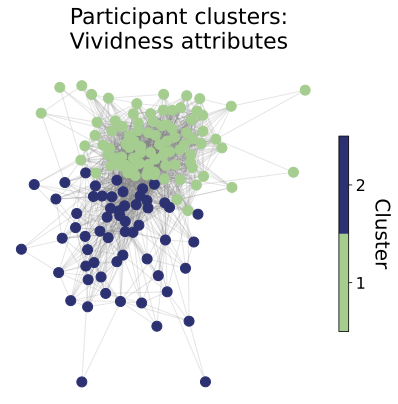

In [58]:
myk = 2

mykmeans = KMeans(n_clusters=myk, init="k-means++",
                  n_init=500,  #number of clustering attempts - returns lowest SSE
                  random_state=r_state).fit(memory_values)

# fetch cluster centroids:
centroids = pd.DataFrame(mykmeans.cluster_centers_, columns = memory_values.columns).reset_index()
kmeans_labels = mykmeans.labels_

plot_distance_network(memory_values, kmeans_labels, prop_view, myk, ran_seed=2)

# save 
plt.savefig("plots/distances_2cluster.pdf", bbox_inches = 'tight')
plt.show()

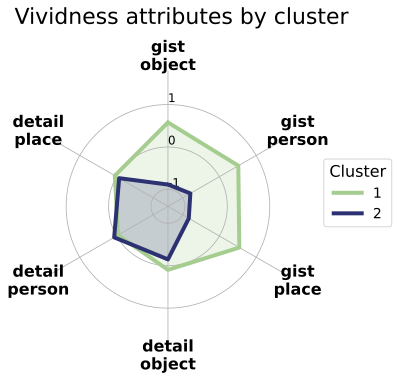

In [59]:
cluster_polar_plot(centroids, myk, -1.4, 1.8)

# save 
plt.savefig("plots/polar_2cluster.pdf", bbox_inches = 'tight')
plt.show()

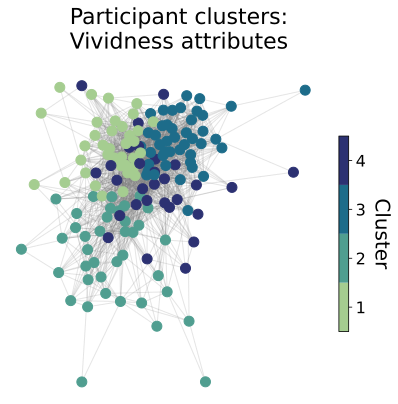

In [60]:
myk = 4

mykmeans = KMeans(n_clusters=myk, init="k-means++",
                  n_init=500,  #number of clustering attempts - returns lowest SSE
                  random_state=r_state).fit(memory_values)

# fetch cluster centroids:
centroids = pd.DataFrame(mykmeans.cluster_centers_, columns = memory_values.columns).reset_index()
kmeans_labels = mykmeans.labels_

plot_distance_network(memory_values, kmeans_labels, prop_view, myk, ran_seed=2)

# save 
plt.savefig("plots/distances_4cluster.pdf", bbox_inches = 'tight')
plt.show()

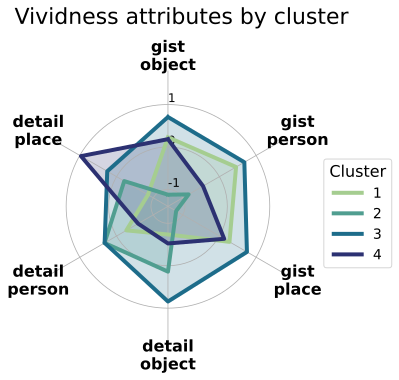

In [61]:
cluster_polar_plot(centroids, myk, -1.4, 1.8)

# save 
plt.savefig("plots/polar_4cluster.pdf", bbox_inches = 'tight')
plt.show()